# SPOT Dataset Exploration with Inspect AI

This notebook explores the SPOT (Scientific Paper Error Detection) dataset and demonstrates how to use Inspect AI for scientific error detection.

## Overview
- Load and explore the SPOT dataset
- Understand the data structure
- Set up Inspect AI for scientific error detection
- Create a simple error detection pipeline

In [1]:
# Install required packages
!pip install datasets pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 28.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [seaborn]m6/7 [seaborn]ib]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import json
from typing import List, Dict, Any

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load the SPOT Dataset

In [8]:
   from datasets import load_dataset

   # Download the SPOT dataset
   dataset = load_dataset("amphora/SPOT", split="train")
   df = dataset.to_pandas()

   print(f" Dataset loaded: {len(df)} papers")
   print(f"Columns: {list(df.columns)}")
   print("\nFirst few rows:")
   print(df.head())

 Dataset loaded: 68 papers
Columns: ['doi/arxiv_id', 'title', 'paper_category', 'error_category', 'error_location', 'error_severity', 'error_annotation', 'paper_content', 'error_local_content', '__index_level_0__']

First few rows:
            doi/arxiv_id                                              title  \
0           2405.01133v3                   A missing theorem on dual spaces   
1           2402.10307v2      A New Radio to Overcome Critical Link Budgets   
2           2406.01892v2  On the triviality of the unramified Iwasawa mo...   
3           2407.06913v2  A Simple, Nearly-Optimal Algorithm for Differe...   
4  10.5539/jsd.v17n6p137  The Scientific Case Against Net Zero: Falsifyi...   

          paper_category    error_category  error_location error_severity  \
0            Mathematics  Equation / proof       Lemma 3,4        retract   
1       Computer Science  Equation / proof         Unknown        retract   
2            Mathematics  Equation / proof   Section 4.2.3    

In [9]:
df.to_json("spot_dataset.json", orient="records", indent=2)

## 2. Dataset Statistics

Dataset Overview:
Total papers: 68
Unique categories: 9
Error severity distribution:
error_severity
errata     37
retract    31
Name: count, dtype: int64

Error Categories:
error_category
Equation / proof                      37
Figure duplication                    12
Data Inconsistency (figure-text)       6
Statistical reporting                  4
Reagent identity                       2
Data inconsistency                     2
Data Inconsistency (text-text)         2
Experiment setup                       2
Data Inconsistency (figure-figure)     1
Name: count, dtype: int64


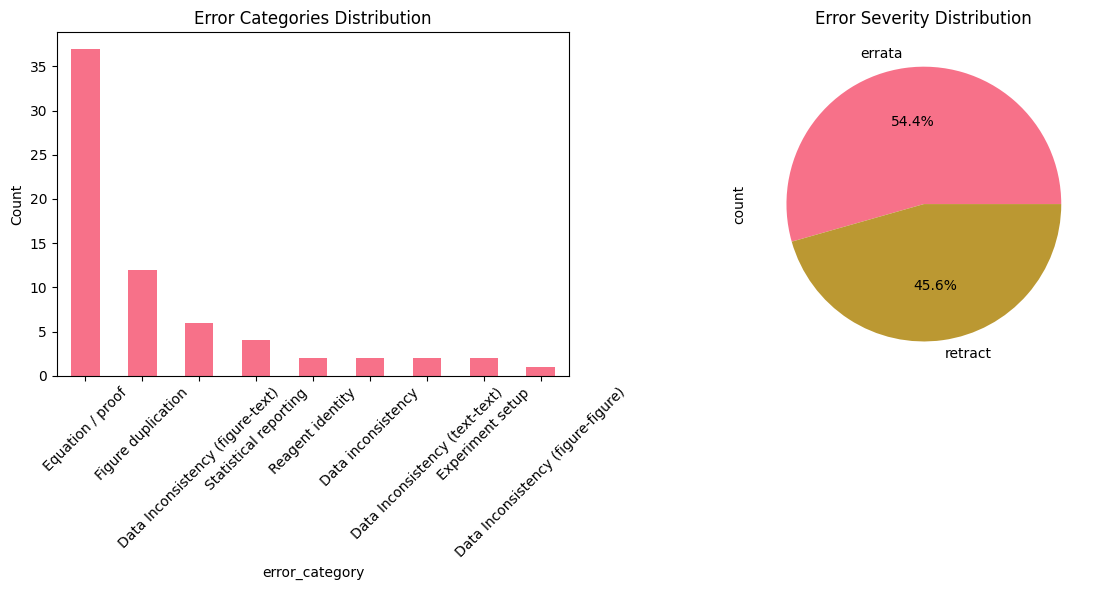

In [11]:
# Basic statistics
print("Dataset Overview:")
print(f"Total papers: {len(df)}")
print(f"Unique categories: {df['paper_category'].nunique()}")
print(f"Error severity distribution:")
print(df['error_severity'].value_counts())

# Error categories
print("\nError Categories:")
error_cats = df['error_category'].value_counts()
print(error_cats)

# Visualize error categories
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
error_cats.plot(kind='bar')
plt.title('Error Categories Distribution')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['error_severity'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Error Severity Distribution')

plt.tight_layout()
plt.show()

## 3. Examine Paper Content Structure

In [13]:
# Look at the structure of paper_content
def analyze_paper_content(content_list: List[Dict]) -> Dict[str, Any]:
    """Analyze the structure of paper content."""
    text_chunks = [c for c in content_list if c.get('type') == 'text']
    image_chunks = [c for c in content_list if c.get('type') == 'image_url']
    
    total_text_length = sum(len(c.get('text', '')) for c in text_chunks)
    
    return {
        'total_chunks': len(content_list),
        'text_chunks': len(text_chunks),
        'image_chunks': len(image_chunks),
        'total_text_length': total_text_length,
        'avg_chunk_length': total_text_length / len(text_chunks) if text_chunks else 0,
    }

# Analyze first few papers
print("Paper Content Analysis:")
for i in range(min(3, len(df))):
    paper = df.iloc[i]
    content_analysis = analyze_paper_content(paper['paper_content'])
    
    print(f"\nPaper {i+1}: {paper['title'][:50]}...")
    print(f"  - Total chunks: {content_analysis['total_chunks']}")
    print(f"  - Text chunks: {content_analysis['text_chunks']}")
    print(f"  - Image chunks: {content_analysis['image_chunks']}")
    print(f"  - Total text length: {content_analysis['total_text_length']:,} chars")
    print(f"  - Error: {paper['error_annotation'][:100]}...")

Paper Content Analysis:

Paper 1: A missing theorem on dual spaces...
  - Total chunks: 14
  - Text chunks: 14
  - Image chunks: 0
  - Total text length: 40,774 chars
  - Error: The issue is that an error in Proposition 2.3 undermines the validity of Lemmas 3 and 4, and Theorem...

Paper 2: A New Radio to Overcome Critical Link Budgets...
  - Total chunks: 23
  - Text chunks: 14
  - Image chunks: 9
  - Total text length: 39,158 chars
  - Error: The error is that the beamforming gain for N antennas is incorrectly calculated as N, when it should...

Paper 3: On the triviality of the unramified Iwasawa module...
  - Total chunks: 52
  - Text chunks: 42
  - Image chunks: 10
  - Total text length: 117,872 chars
  - Error: There is a mathematical error in Section 4.2.3, where either an equation is misstated, a step in a p...


## 4. Set Up Inspect AI for Error Detection

In [ ]:

import json
import pandas as pd
from datasets import load_dataset
from inspect_ai import task, eval
from inspect_ai.model import Model
from inspect_ai.dataset import Dataset
from typing import List, Dict, Any

# Load the SPOT dataset
def load_spot_dataset():
    """Load and prepare the SPOT dataset"""
    dataset = load_dataset("amphora/SPOT", split="train")
    df = dataset.to_pandas()
    print(f"Loaded {len(df)} papers from SPOT dataset")
    return df

@task
def evaluate_scientific_error(paper_content: List[Dict], error_annotation: str) -> Dict[str, Any]:
    """
    Evaluate if an LLM can detect scientific errors in a paper
    
    Args:
        paper_content: List of content chunks (text and images)
        error_annotation: Human annotation describing the error
    
    Returns:
        Dict containing evaluation results
    """
    # Convert paper content to a readable format
    paper_text = ""
    for chunk in paper_content:
        if chunk.get("type") == "text":
            paper_text += chunk.get("text", "") + "\n"
    
    # Create the evaluation prompt
    prompt = f"""
You are a scientific rigor auditor. Analyze the following research paper and identify any errors that directly undermine the scientific validity of the paper's methods, analyses, or conclusions.

PAPER CONTENT:
{paper_text[:2000]}...  # Truncated for brevity

HUMAN ANNOTATION OF KNOWN ERROR:
{error_annotation}

Your task is to:
1. Identify if there are any scientific errors in the paper
2. Describe any errors you find
3. Compare your findings with the human annotation

Please respond in the following JSON format:
{{
    "errors_detected": true/false,
    "error_description": "description of errors found",
    "matches_human_annotation": true/false,
    "confidence": 0.0-1.0
}}
"""
    
    return {
        "paper_text": paper_text[:500],  # First 500 chars for reference
        "human_annotation": error_annotation,
        "prompt": prompt
    }

@task
def score_error_detection(response: str, human_annotation: str) -> Dict[str, float]:
    """
    Score the LLM's error detection against human annotation
    
    Args:
        response: LLM's response
        human_annotation: Human annotation of the error
    
    Returns:
        Dict with scoring metrics
    """
    try:
        # Parse LLM response
        if isinstance(response, str):
            # Try to extract JSON from response
            import re
            json_match = re.search(r'\{.*\}', response, re.DOTALL)
            if json_match:
                parsed_response = json.loads(json_match.group())
            else:
                parsed_response = {"errors_detected": False, "error_description": response}
        else:
            parsed_response = response
        
        # Simple scoring logic
        errors_detected = parsed_response.get("errors_detected", False)
        matches_human = parsed_response.get("matches_human_annotation", False)
        confidence = parsed_response.get("confidence", 0.0)
        
        # Calculate scores
        accuracy = 1.0 if errors_detected == (len(human_annotation.strip()) > 0) else 0.0
        match_score = 1.0 if matches_human else 0.0
        
        return {
            "accuracy": accuracy,
            "match_score": match_score,
            "confidence": confidence,
            "errors_detected": errors_detected
        }
        
    except Exception as e:
        return {
            "accuracy": 0.0,
            "match_score": 0.0,
            "confidence": 0.0,
            "error": str(e)
        }

def create_evaluation_dataset(df: pd.DataFrame, max_samples: int = 10) -> Dataset:
    """Create an inspect_ai Dataset from SPOT data"""
    
    # Sample a subset for evaluation
    sample_df = df.head(max_samples)
    
    # Create dataset items
    items = []
    for _, row in sample_df.iterrows():
        items.append({
            "paper_id": row["doi/arxiv_id"],
            "title": row["title"],
            "paper_content": row["paper_content"],
            "error_annotation": row["error_annotation"],
            "error_category": row["error_category"],
            "error_location": row["error_location"],
            "error_severity": row["error_severity"]
        })
    
    return Dataset(items)

def run_evaluation(model_name: str = "gpt-4", max_samples: int = 5):
    """Run the complete evaluation"""
    
    print("🔬 Starting SPOT Dataset Evaluation")
    print("=" * 50)
    
    # Load dataset
    df = load_spot_dataset()
    
    # Create evaluation dataset
    eval_dataset = create_evaluation_dataset(df, max_samples)
    
    # Initialize model
    model = Model(model_name)
    
    # Run evaluation
    results = eval(
        eval_dataset,
        evaluate_scientific_error,
        model=model,
        scorer=score_error_detection
    )
    
    # Print results
    print("\n📊 Evaluation Results:")
    print("=" * 30)
    
    accuracy_scores = [r.get("accuracy", 0.0) for r in results.scores]
    match_scores = [r.get("match_score", 0.0) for r in results.scores]
    confidence_scores = [r.get("confidence", 0.0) for r in results.scores]
    
    print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.3f}")
    print(f"Average Match Score: {sum(match_scores) / len(match_scores):.3f}")
    print(f"Average Confidence: {sum(confidence_scores) / len(confidence_scores):.3f}")
    
    # Save detailed results
    results_df = pd.DataFrame(results.scores)
    results_df.to_csv(f"spot_evaluation_results_{model_name.replace('/', '_')}.csv", index=False)
    print(f"\n💾 Detailed results saved to: spot_evaluation_results_{model_name.replace('/', '_')}.csv")
    
    return results

if __name__ == "__main__":
    # Run evaluation with a small sample first
    run_evaluation(model_name="gpt-4", max_samples=3) 

  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl.metadata (3.0 kB)
  Using cached jsonlines-4.0.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached jsonpath_ng-1.7.0-py3-none-any.whl.metadata (18 kB)
  Using cached jsonref-1.1.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached semver-3.0.4-py3-none-any.whl.metadata (6.8 kB)
  Using cached shortuuid-1.0.13-py3-none-any.whl.metadata (5.8 kB)
  Using cached textual-2.1.2-py3-none-any.whl.metadata (9.0 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached ply-3.11-py2.py3-none-any.whl.metadata (844 bytes)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  

ImportError: cannot import name 'InspectAI' from 'inspect_ai' (/Users/tommyly/ai4s_r2/spot_env/lib/python3.13/site-packages/inspect_ai/__init__.py)

In [ ]:
# Create a simple error detection prompt
ERROR_DETECTION_PROMPT = """
You are a scientific rigor auditor. Analyze the following research paper content and identify any errors or flaws that directly undermine the scientific validity of the paper's methods, analyses, or conclusions.

Focus on:
- Errors in experimental design
- Data integrity issues
- Calculation errors
- Statistical inference problems
- Reproducibility issues
- Figure/image duplications or manipulations

Do NOT report:
- Purely presentational issues
- Stylistic problems
- Citation practice issues

Paper Content:
{paper_content}

Provide your analysis in this format:
```json
{
  \"has_error\": true/false,
  \"errors\": [
    {
      \"location\": \"Section/Figure/Table identifier\",
      \"description\": \"Detailed description of the scientific error\",
      \"severity\": \"high/medium/low\"
    }
  ]
}
```
"""

print("📝 Error detection prompt created")

## 5. Create a Simple Error Detection Pipeline

In [ ]:
def prepare_paper_content(content_list: List[Dict]) -> str:
    """Convert paper content list to a readable string for LLM analysis."""
    text_parts = []
    
    for i, chunk in enumerate(content_list):
        if chunk.get('type') == 'text':
            text_parts.append(f"[Chunk {i+1}] {chunk.get('text', '')}")
        elif chunk.get('type') == 'image_url':
            text_parts.append(f"[Chunk {i+1}] [IMAGE: {chunk.get('image_url', {}).get('url', '')[:50]}...]")
    
    return "\n\n".join(text_parts)

def detect_errors_simple(paper_content: str, model_name: str = "gpt-4") -> Dict:
    """Simple error detection using Inspect AI."""
    # This is a placeholder - you'll need to implement actual Inspect AI calls
    # based on your specific setup and API access
    
    prompt = ERROR_DETECTION_PROMPT.format(paper_content=paper_content[:2000])  # Limit content length
    
    # Placeholder response - replace with actual LLM call
    response = {
        "has_error": True,
        "errors": [
            {
                "location": "Example Section",
                "description": "This is a placeholder error detection result",
                "severity": "medium"
            }
        ]
    }
    
    return response

print("🔧 Error detection pipeline created")

In [ ]:
# Test the pipeline on a single paper
test_paper = df.iloc[0]
paper_content_str = prepare_paper_content(test_paper['paper_content'])

print(f"🧪 Testing error detection on: {test_paper['title']}")
print(f"📄 Content length: {len(paper_content_str)} characters")
print(f"🎯 Known error: {test_paper['error_annotation'][:200]}...")

# Run error detection (placeholder)
result = detect_errors_simple(paper_content_str)
print(f"\n🔍 Detection result: {result}")